In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('wineQualityReds.csv')
data.head()

,Unnamed: 0,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# Número de registros por categoría en 'quality':
data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [4]:
# Información básica del dataframe:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
Unnamed: 0              1599 non-null int64
fixed.acidity           1599 non-null float64
volatile.acidity        1599 non-null float64
citric.acid             1599 non-null float64
residual.sugar          1599 non-null float64
chlorides               1599 non-null float64
free.sulfur.dioxide     1599 non-null float64
total.sulfur.dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(2)
memory usage: 162.5 KB


In [5]:
# Eliminación columna 'Unnamed: 0'
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


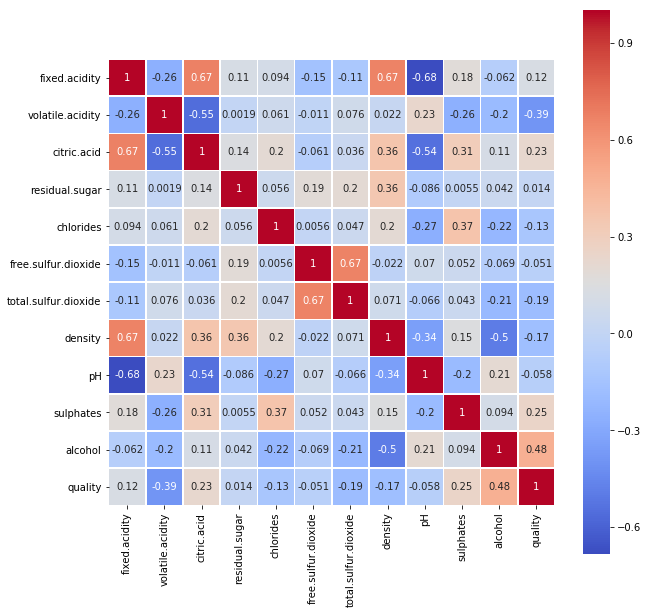

In [6]:
# Comprobación de correlación entre las variables -> No hay variables con alta correlación
corr_matrix = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, square=True, linewidth = 0.5, cmap='coolwarm')

In [7]:
# Agrupación de calidades en baja, media, alta. 
# Ojo, en modelos de clasificación el typo de datos contenidos en 'y' debe ser int
bins = [0, 4, 7, 10]
labels= [1, 2, 3]  # 1: baja, 2: media, 3:alta
data['quality_binned'] = pd.cut(x=data['quality'], bins=bins, labels=labels)
data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,quality_binned
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,2


In [8]:
# Número de registros por bin -> La mayor parte de los vinos tinen calidad media
data['quality_binned'].value_counts()

2    1518
1      63
3      18
Name: quality_binned, dtype: int64

In [9]:
# Selección de los features:
cols = data.columns[:11]
features = data[cols]
# Normalización de los features -> valores entre 0 y 1:
scaler = StandardScaler()
X = scaler.fit_transform(features)
X = pd.DataFrame(X)
X.shape

(1599, 11)

In [10]:
# Selección de y:
y = data['quality_binned']
y.shape

(1599,)

In [11]:
# División en set de entrenamiento y set de verificación:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
# Modelos:
clasif1 = RandomForestClassifier(n_estimators=100)
clasif2 = KNeighborsClassifier(n_neighbors=1)
clasif3 = SVC(gamma='scale')

In [13]:
# Cross validation, para evaluar los modelos:
scores1 = cross_val_score(clasif1, X, y, cv=3)  
scores2 = cross_val_score(clasif2, X, y, cv=3)
scores3 = cross_val_score(clasif1, X, y, cv=3)
# scores dará un resultado por cada split. Hay que calcular la media. Para un intervalo de confianza del 95%:
print('RandomForestClassifier: {:.3f} (+/- {:.2f})'.format(scores1.mean(), scores1.std() * 2))
print('KNeighborsClassifier: {:.3f} (+/- {:.2f})'.format(scores2.mean(), scores2.std() * 2))
print('SVC: {:.3f} (+/- {:.2f})'.format(scores3.mean(), scores3.std() * 2))

RandomForestClassifier: 0.947 (+/- 0.01)
KNeighborsClassifier: 0.911 (+/- 0.01)
SVC: 0.947 (+/- 0.01)


In [14]:
# El modelo que da un mejor resultado es 'RandomForestClassifier'. Creamos variantes de los parámetros de este modelo:
grid_param = {  
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],   
    'bootstrap': [True, False]
}

In [15]:
# Creamos el grid search:
gd_sr = GridSearchCV(estimator=clasif1,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)  # -1 -> use all available computing power

In [16]:
# Entrenamos el modelo:
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [100, 300, 500, 800, 1000], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [17]:
# Parámetros que dan el mejor resultado:
best_parameters = gd_sr.best_params_ 
best_parameters

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 500}

In [18]:
# Resultado usando los mejores parámetros del modelo
best_result = gd_sr.best_score_  
best_result


0.9538702111024238